<img src="../assets/header.gif"
     width="4000" 
     height="100"/>
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2.5vw; color:#c6cde1; font-weight:bold;">
    Upper-level: BFM models comparion
    </b>
</p>
<hr style="color:#c6cde1;">
<b>Description</b><br>
<p align="justify">
    The purpose of this notebook is to compare several BFM formulations
    <ul>
        <li style="margin-bottom:10px"> A first one that considers two continuous variables to represent a line power flow and one binary variable to see if a line has been built,</li>
        <li style="margin-bottom:10px"> A second one that considers only one continuous variable to represent a line power flow and two binary variables to see if a line has been built and in which direction</li>
    </ul> 
<br>
<b>Author</b><br><br> 
<i>Manon Cornet</i>

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    1. Initialization
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Initialize all the librairies needed for the project;</li>
        <li style="margin-bottom:10px">Include the codes containing the two formulations</li>
    </ul> 

In [3]:
# -- LIBRAIRIES --#

import XLSX, DataFrames
using JuMP, Gurobi, Printf, Dates
using GraphRecipes, Graphs
using Test
using LaTeXStrings
#ENV["MPLBACKEND"]="tkagg"
ENV["JULIA_PYTHONCALL_EXE"] = "@PyCall"
using PyPlot, Plots
#pygui(true)

In [22]:
# -- MODEL FILES --

include("UL_BFM.jl")

UL_BFM_2P (generic function with 1 method)

In [23]:
# -- FUNCTION TO PRINT TITLE --

function print_title(title::String)
    println(title)
    for i in 1:length(title) @printf("-") end
    @printf("\n")
end

print_title (generic function with 1 method)

In [24]:
# -- FUNCTION TO PRINT 1D ARRAY --

function print_vector(vector::Vector{<:Number}, units)
    println("["*join(vector, ", ")*"] [$units]")
end

print_vector (generic function with 1 method)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    2. Definition of the network model 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Load a network model from an Excel file;</li>
        <li style="margin-bottom:10px">Initialize the parameters defining the network</li>
    </ul> 

In [25]:
# -- LOADING OF THE EXCEL FILE --

XLSX_FILE_PATH = joinpath(splitdir(@__DIR__)[1], "network_models/network_Nahman_Peric_2S23H.xlsx")

"/Users/manoncornet/Documents/University/TFE/DNEP/network_models/network_Nahman_Peric_2S23H.xlsx"

In [26]:
# -- DEFINITION OF THE PER UNIT BASIS --
# Values obtained by reading the Paper "A Constructive Heuristic Algorithm for Distribution System Planning"

const BASE_VOLTAGE    = 34.5                             # [kV]
const BASE_POWER      = 1                                # [MVA]
const BASE_CURRENT    = BASE_POWER / BASE_VOLTAGE        # [kA]
const BASE_ADMITTANCE = BASE_CURRENT / BASE_VOLTAGE      # [S]
const BASE_IMPEDANCE  = 1/BASE_ADMITTANCE                # [Ohm]
print_title("Per-unit basis:")

@printf("Base Admittance : %.3e [S]\n", BASE_ADMITTANCE)
@printf("Base Impedance  : %.3e [Ohm]\n", BASE_IMPEDANCE)
@printf("Base Voltage    : %.3e [kV]\n", BASE_VOLTAGE)
@printf("Base Current    : %.3e [kA]\n", BASE_CURRENT)
@printf("Base Power      : %.3e [MVA]\n", BASE_POWER)

Per-unit basis:
---------------
Base Admittance : 8.402e-04 [S]
Base Impedance  : 1.190e+03 [Ohm]
Base Voltage    : 3.450e+01 [kV]
Base Current    : 2.899e-02 [kA]
Base Power      : 1.000e+00 [MVA]


In [27]:
# -- FUNCTION THAT PROCESSES THE LINE PROPRETIES  --

function process_conductors(df_cond::DataFrames.DataFrame, 
                            len_lines::Vector{Float64},  
                            nb_lines::Integer, 
                        )

    nb_cond = DataFrames.nrow(df_cond)
    max_i   = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    r       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    x       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    g       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    b       = Array{Float64}(undef, nb_lines, nb_cond) # absolute, [pu]
    
    line_cost = Array{Float64}(undef, nb_lines, nb_cond) # [€/km]

    # Only take the first conductors of the list in the file
    for l in 1:nb_lines
        for k in 1:nb_cond
            max_i[l, k] = df_cond.max_i_ka[k] ./ BASE_CURRENT

            r[l, k] = len_lines[l] * df_cond.r_ohm_per_km[k] ./ BASE_IMPEDANCE
            x[l, k] = len_lines[l] * df_cond.x_ohm_per_km[k] ./ BASE_IMPEDANCE
            y = 1/(r[l, k]+im*x[l, k])

            g[l, k] = real(y) 
            b[l, k] = abs(imag(y))

            line_cost[l, k] = df_cond.cost_kdollars_per_km[k] * len_lines[l]
        end
    end
    return max_i, line_cost, r, x, g, b
end

process_conductors (generic function with 1 method)

In [28]:
# -- FETCH THE DATA FROM THE EXCEL SHEET --

df_bus  = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "bus"))
df_line = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "line"))
df_cond = DataFrames.DataFrame(XLSX.readtable(XLSX_FILE_PATH, "conductor"))

Row,idx,Name,d_mm,q_mm2,r_ohm_per_km,x_ohm_per_km,max_i_ka,cost_kdollars_per_km
,Any,Any,Any,Any,Any,Any,Any,Any
1,1,AAC (1/0),9.35,1,0.5502,0.429,0.23,10
2,2,AAC (4/0),13.26,107.3,0.2747,0.402,0.34,20


In [29]:
# -- LINE PARAMETERS DEFINITION --

L_size = DataFrames.nrow(df_line)                                   # Number of lines in the network
L      = 1:L_size                                                   # Line set
line_ends = [(df_line.from_bus[l], df_line.to_bus[l]) for l in L]   # Indices of the line extremities
len_lines = convert(Vector{Float64}, df_line.length_km)             # Line lengths [km]

print_title("Network lines summary:")
@printf("Number of lines : %d\n", L_size)

Network lines summary:
----------------------
Number of lines : 34


In [30]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK LINES --

K_size = DataFrames.nrow(df_cond)   # Number of conductor types
K      = 1:K_size                   # Set of conductors

max_i, line_cost, R, X, G, B, = process_conductors(df_cond, len_lines, L_size)

print_title("Conductor properties:")
println(df_cond)

Conductor properties:
---------------------
2×8 DataFrame
 Row │ idx  Name       d_mm   q_mm2  r_ohm_per_km  x_ohm_per_km  max_i_ka  cost_kdollars_per_km 
     │ Any  Any        Any    Any    Any           Any           Any       Any                  
─────┼──────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1    AAC (1/0)  9.35   1      0.5502        0.429         0.23      10
   2 │ 2    AAC (4/0)  13.26  107.3  0.2747        0.402         0.34      20


In [31]:
# -- BUS PARAMETERS DEFINITION --

N_size = DataFrames.nrow(df_bus)            # Number of buses in the network
N      = 1:N_size                           # Buses set

Ns_size = sum(df_bus.type .== "substation") # Number of substation buses
Nu_size = sum(df_bus.type .== "user")       # Number of load nodes

Ns = 1:Ns_size                              # Set of substation buses
Nu = (1:Nu_size) .+ Ns_size                 # Set of load buses

print_title("Network buses summary:")
@printf("Number of buses            : %d\n", N_size)
@printf("Number of load buses       : %d\n", Nu_size)
@printf("Number of substation buses : %d\n", Ns_size)

Network buses summary:
----------------------
Number of buses            : 23
Number of load buses       : 21
Number of substation buses : 2


In [32]:
# -- DEFINITION OF THE PHYSICAL QUANTITIES ASSOCIATED TO NETWORK BUSES --

# Limits on voltage
MIN_VOLTAGE = 0.97  # [pu]
MAX_VOLTAGE = 1.03  # [pu]

# Demand at buses
# Assumption: load power factor is constant for all loads and is lagging (inductive)
cos_phi = 0.9
S_D     = convert(Vector{Float64}, df_bus.S_D_mva) ./ BASE_POWER
P_D     = S_D * cos_phi
Q_D     = S_D * sin(acos(cos_phi))

print_title("Network buses additional info:")
@printf("Power factor  : %.3g\n", cos_phi)
@printf("Voltage range : [%1.3g, %1.3g] [pu]", MIN_VOLTAGE, MAX_VOLTAGE)

Network buses additional info:
------------------------------
Power factor  : 0.9
Voltage range : [0.97, 1.03] [pu]

In [33]:
# -- SUBSTATION PARAMETERS DEFINITION --

S_rating_init    = convert(Vector{Float64}, df_bus.S_G_init_mva[Ns]) ./ BASE_POWER # [pu]
S_rating_max     = convert(Vector{Float64}, df_bus.S_G_max_mva[Ns]) ./ BASE_POWER # [pu]
sub_install_cost = 1e3      # k$
sub_op_cost      = 0.1*1e-3 # k$/kVah^2

print_title("Substation buses additional info:")
print("Initial rating of substations: "); print_vector(S_rating_init, "pu");
print("Maximum rating of substations: "); print_vector(S_rating_max, "pu");
@printf("Substation construction cost : %.3g [k\$]\n", sub_install_cost)
@printf("Substation operation cost    : %.3g [k\$/kVA^2]", sub_op_cost)

Substation buses additional info:
---------------------------------
Initial rating of substations: [4.0, 0.0] [pu]
Maximum rating of substations: [4.0, 4.0] [pu]
Substation construction cost : 1e+03 [k$]
Substation operation cost    : 0.0001 [k$/kVA^2]

In [34]:
# -- LINK BTW LINES AND NODES --

Omega_sending   = Dict(n => [] for n in N)
Omega_receiving = Dict(n => [] for n in N)
for l in L
    push!(Omega_sending[line_ends[l][1]], l)
    push!(Omega_receiving[line_ends[l][2]], l)
end

print_title("Link btw lines and nodes:")
println("Omega sending  : $Omega_sending")
println("Omega receiving: $Omega_receiving")

Link btw lines and nodes:
-------------------------
Omega sending  : Dict{Int64, Vector{Any}}(5 => [21, 22], 16 => [], 20 => [], 12 => [18], 8 => [28, 29, 30, 33], 17 => [17], 1 => [1], 19 => [5, 6, 7], 22 => [8, 9], 23 => [19, 20], 6 => [25, 26], 11 => [10, 11], 9 => [32], 14 => [24], 3 => [34], 7 => [27], 4 => [23, 31], 13 => [12], 15 => [13, 14, 15], 2 => [], 10 => [2, 3, 4], 18 => [16], 21 => [])
Omega receiving: Dict{Int64, Vector{Any}}(5 => [20], 16 => [8, 25, 34], 20 => [2, 5], 12 => [15], 8 => [27], 17 => [16], 1 => [], 19 => [4], 22 => [7], 23 => [18], 6 => [23, 24], 11 => [9], 9 => [29, 31], 14 => [3, 17, 19, 21], 3 => [32, 33], 7 => [26], 4 => [22, 30], 13 => [11], 15 => [12], 2 => [28], 10 => [1], 18 => [14], 21 => [6, 10, 13])


[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    3. Definition of the objective function parameters 
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [35]:
# -- FUNCTION FOR COMPUTING THE NPV --

function PV_coeff(tau, lambda)
    return (1 - 1/(1 + tau)^lambda)/tau  
end

# Capital recovery rate formula
# tau: interest rate 
# n : number of annuity received
function CRF(tau, n)
    return (tau * (1 + tau)^n)/((1 + tau)^n - 1)  
end

CRF (generic function with 1 method)

In [36]:
# -- OBJECTIVE FUNCTION PARAMETERS --

nb_years_planning = 1
delta_t           = 1 # [h]

tau = 0.1

line_loss_factor = 0.35     # phi_l : loss factor of lines
sub_loss_factor  = 0.35     # phi_s : cost per energy lost [€/kWh]

K_l = CRF(tau, 1)           # Capital recovery rate of line constructions
K_s = CRF(tau, 1)           # Capital recovery rate of substation construction or reinforcement

loss_cost = 0.05*1e-3       # [k$/kWh]
tau_l     = tau             # tau_l : interest rate of circuits
tau_s     = tau             # tau_s : interest rate of substations

f_l = PV_coeff(tau_l, nb_years_planning)
f_s = PV_coeff(tau_s, nb_years_planning)

0.9090909090909094

In [37]:
# -- CREATION OF THE NETWORK DICT --
# Rmq: all the costs are in k$
Ns_init = [1]
network_dict = Dict(:bus       => (N, Omega_sending, Omega_receiving, MIN_VOLTAGE, MAX_VOLTAGE),
                    :load_bus  => (Nu, P_D, Q_D, delta_t),
                    :sub_bus   => (Ns, S_rating_init, S_rating_max),
                    :line      => (L, line_ends, max_i, R, X, G, B),
                    :conductor => (K)
                    )

BFM_obj_fct_dict = Dict(:LF  => (line_loss_factor, sub_loss_factor),
                        :CRF => (K_l, K_s),
                        :NPV_coeff => (f_l, f_s),
                        :costs => (loss_cost, sub_install_cost, sub_op_cost, line_cost)
                        )

Dict{Symbol, Tuple{Float64, Float64, Vararg{Any}}} with 4 entries:
  :NPV_coeff => (0.909091, 0.909091)
  :LF        => (0.35, 0.35)
  :CRF       => (1.1, 1.1)
  :costs     => (5.0e-5, 1000.0, 0.0001, [2.02092 4.04183; 6.97278 13.9456; … ;…

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    4. Test of the two branch flow models
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [18]:
# -- BFM1P FORMULATION --
BFM1P_obj_value, BFM1P_var_values, BFM1P_var_dict, BFM1P_solve_time = UL_BFM_1P(network_dict, BFM_obj_fct_dict)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0


LoadError: InterruptException:

In [ ]:
# -- BFM2P FORMULATION --
BFM2P_obj_value, BFM2P_var_values, BFM2P_var_dict, BFM2P_solve_time = UL_BFM_2P(network_dict, BFM_obj_fct_dict)

In [ ]:
# -- COMPARE RESULTS --
print_title("Computation time:")
@printf("BFM1P: %g [s] ", BFM1P_solve_time) 
@printf(" | ")
@printf(" BFM2P: %g [s]\n\n", BFM2P_solve_time) 
print_title("Objective value:")
@printf("BFM1P: %g [k\$] ", BFM1P_obj_value) 
@printf(" | ")
@printf(" BFM2P: %g [k\$]\n", BFM2P_obj_value)

In [45]:
# -- SHAPES OF THE NODES OF THE NETWORK --

house_nodeshape(x_i, y_i, s) = 
[
    (x_i + 0.7s * dx, y_i + 0.7s * dy) 
    for (dx, dy) in [(1, 1), (0, 1.6), (-1,1), (-1, -1), (1, -1), (1, 1)]
]

subs_nodeshape(x_i, y_i, s) = [
    (x_i + 0.8s * dx, y_i + 0.8s * dy) 
    for (dx, dy) in [(1, 1), (-1, 1), (-1, -1), (1, -1), (1,1)]
]

subs_nodeshape (generic function with 1 method)

In [44]:
# -- FUNCTION THAT PRINTS THE NETWORK --

function print_network(nb_nodes::Int64, nb_sub_nodes::Int64, line_ends::Vector{Tuple{Int64, Int64}}, var_values; two_P::Bool=true)

    L  = 1:length(line_ends)
    N  = 1:nb_nodes 
    Ns = 1:nb_sub_nodes
    Nu = setdiff(N, Ns)

    alpha = sum(var_values["alpha"], dims=2)
    edge_label_dict = Dict{Tuple{Int64, Int64}, Float64}()
    
    if two_P
        P_ij = sum(var_values["P_ij"], dims=2) .* BASE_POWER
        P_ji = sum(var_values["P_ji"], dims=2) .* BASE_POWER

        line_power = [(P_ij[l] >= 0 ? P_ij[l] : abs(P_ji[l])) for l in L]
    else
        P_ij = var_values["P_ij"] .* BASE_POWER
        I_sqr = var_values["I_sqr"]

        line_power = [(P_ij[l] >= 0 ? P_ij[l] : abs(P_ij[l] - R[l]*I_sqr[l])) for l in L]
    end

    edge_width = Dict()
    g = SimpleDiGraph(nb_nodes)
    for l in L
        if P_ij[l] < 0
            add_edge!(g, line_ends[l][2], line_ends[l][1])
            key = (line_ends[l][2], line_ends[l][1])
        else
            add_edge!(g, line_ends[l][1], line_ends[l][2])
            key = line_ends[l]
        end
        if isapprox(alpha[l], 1; rtol = 1e-4) # TO BE MODIFIED        
            edge_label_dict[key] = abs(round(line_power[l]; digits=4))
        end

        edge_width[key] = (isapprox(alpha[l], 1; rtol = 1e-4) ? 1 : 0.1)
    end
    colors = [colorant"lightseagreen", colorant"orange"]
  
    #=
    house_lables = Vector{String}(undef, length(Nu))
    subs_lables  = Vector{String}(undef, length(Ns))
    for n in Nu 
        P_G = round(var_values["P_G"][n]*BASE_POWER; digits=3)
        P_D = round(P_D[n]*BASE_POWER; digits=3)
        house_labels[n] = "+$(P_G) \n\n -$(P_D)"
    end 
    =#
    house_labels = ["+$(round(var_values["P_G"][n]*BASE_POWER, digits=3)) \n\n -$(round(P_D[n]*BASE_POWER, digits=3))" for n in Nu]
    subs_labels  = ["+$(round(var_values["P_G"][n]*BASE_POWER, digits=3))" for n in Ns]
    node_labels  = [subs_labels; house_labels]
    node_shapes  = [[subs_nodeshape for _ in Ns];[house_nodeshape for _ in Nu]]

    # See components.jl from Plots.jl to have all the argumentd
    graph  = graphplot( adjacency_matrix(g),
                        x               = [ [df_bus.x[n] + 0.5 for n in Ns];
                                            [df_bus.x[n] for n in Nu]],             # x-coordinate of the nodes
                        y               = df_bus.y,                                 # y-coordinate of the nodes
                        nodesize        = 0.19,
                        nodestrokewidth = 0,                                        # coutour line width of the node
                        edgestyle       = :solid,
                        nodealpha       = 1,                                        # transparency of node color
                        names           = node_labels,                              # node label
                        nodeshape       = node_shapes,                              # :circle, :ellipse, :hexagon
                        nodecolor       = colors[[[1 for _ in Ns];[2 for _ in Nu]]],
                        curves          = false,                                    # if an edge is curved or not
                        arrow           = Plots.arrow(:closed, 0.8, 0.8),                 # other choices : :open, :closed
                        ew              = edge_width,
                        shorten         = 0.05,
                        edgelabel       = edge_label_dict,
                        edgelabeloffset = 3,
                        axis_buffer     = 0.1,
                        fontsize        = 8,
                        size            = (1000, 3000)
                    )
    return graph
end

print_network (generic function with 1 method)

In [ ]:
# -- FUNCTION THAT WRITES RESULTS IN XLSX FILES -- 

function write_results(XLSX_PATH::String, 
                      var_values::Dict, var_sets::Dict;
                      date_range = nothing
                      )

    for (key, value) in var_values
        if ndims(value) <= 2
            add_var_to_XLSX(XLSX_PATH, value, key, var_sets[key], date_range = date_range)
    
        elseif ndims(value) == 3
             X_i_ij = process_X_i_ij(value)
            add_var_to_XLSX(XLSX_PATH, X_i_ij, "X_i_ij", var_sets[key], date_range = date_range)
        end
    end
    
    return
end

In [ ]:
# -- SAVING THE RESULTS OF THE MODELS IN EXCEL FILES --

include("post_process.jl")

XLSX_PATH_BFM1P = "output/BFM1P_output.xlsx"
XLSX_PATH_BFM2P  = "output/BFM2P_output.xlsx"

write_results(XLSX_PATH_BFM1P, BFM1P_var_values, BFM1P_var_dict)
write_results(XLSX_PATH_BFM2P, BFM2P_var_values, BFM2P_var_dict)


In [ ]:
# -- PRINTING THE NETWORK --

pyplot()
graph1 = print_network(length(N), length(Ns), line_ends, BFM1P_var_values, two_P = false)

graph2 = print_network(length(N), length(Ns), line_ends, BFM2P_var_values)

println("Formulation with 1P")
display(graph1)

println("Formulation with 2P")
display(graph2)

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    5. Add generation and radiality constraints
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Add generation to load nodes and verify the radiality of the network;</li>
    </ul> 

In [ ]:
# -- BFM1P FORMULATION + generation --
gen_obj_value, gen_var_values, gen_var_dict, gen_solve_time = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 0, generation=true)

In [ ]:
# -- BFM1P FORMULATION + generation + radiality --
genrad_obj_value, genrad_var_values, genrad_var_dict, genrad_solve_time = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 1, generation=true)

In [ ]:
# -- COMPARE RESULTS --
print_title("Computation time:")
@printf("BFM generation: %g [s] ", gen_solve_time ) 
@printf(" | ")
@printf("BFM generation + radiality constraint: %g [s]\n\n", genrad_solve_time) 
print_title("Objective value:")
@printf("BFM generation: %g [k\$] ", gen_obj_value) 
@printf(" | ")
@printf("BFM generation + radiality constraint:: %g [k\$]\n", genrad_obj_value)

In [ ]:
# -- SAVING THE RESULTS OF THE MODELS IN EXCEL FILES --

include("post_process.jl")

XLSX_PATH_BFMgen = "output/BFMgen_output.xlsx"
XLSX_PATH_BFMgenrad  = "output/BFMgenrad_output.xlsx"

write_results(XLSX_PATH_BFMgen, gen_var_values, gen_var_dict)
write_results(XLSX_PATH_BFMgenrad, genrad_var_values, genrad_var_dict)


In [ ]:
# -- PRINTING THE NETWORK --

pyplot()

graph1 = print_network(length(N), length(Ns), line_ends, gen_var_values, two_P = false)

graph2 = print_network(length(N), length(Ns), line_ends, genrad_var_values, two_P = false)
display(Plots.plot(graph1, graph2,layout=(1, 2)))

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    6. Compare the four types of radiality constraints
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">To compare 4 types of radiality constraints;</li>
    </ul> 

In [38]:
# -- BFM1P FORMULATION + single-commodity flow (V1) --
rad1_obj_value, rad1_var_values, rad1_var_dict, rad1_solve_time = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 1, generation=true)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3104 rows, 3018 columns and 8106 nonzeros
Model fingerprint: 0xa96c0356
Model has 4 quadratic objective terms
Model has 36 quadratic constraints
Variable types: 534 continuous, 2484 integer (1702 binary)
Coefficient statistics:
  Matrix range     [1e-09, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-06, 1e+03]
  QObjective range [6e-01, 6e-01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-01, 2e+01]
Variable types: 533 continuous, 2485 integer (1702 binary)

Root relaxation: objective 1.716263e+02, 3283 iterations, 0.02 seconds (0.01 work unit

(178.5022175914773, Dict{String, Array{Float64}}("Q_G" => [-5.030271809477647e-8, 0.0, 0.27916277178605264, 0.13707172681904148, 0.1647374451656053, 0.1385725870943504, 0.13963947201497545, 0.14083116000176388, 0.13946459867756153, 0.1015362030715358  …  0.15140175170713074, 0.17054275746663086, 0.14734044460220808, 0.13976465272354058, 0.10986301004155083, 0.13990347480079146, 0.15056319887098218, 0.1406402726782212, 0.13759304385146948, 0.14483184163295051], "k_ij" => [0.0 0.0 … 1.0 1.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], "x_span_ij" => [0.0 -0.0 … -0.0 -0.0; -0.0 0.0 … -0.0 -0.0; … ; -0.0 -0.0 … -0.0 -0.0; -0.0 -0.0 … -0.0 -0.0], "Q_ij" => [-5.030271809477647e-8, -0.011078269663521212, -0.01933278152184453, -0.007537646838376101, 0.0, -0.0011554031082484143, -0.0059636730522916355, -0.00785552803253474, 0.0, 0.0  …  0.0, -0.0015221903656869823, -0.0014867322672587604, 0.0, -0.00017028962458123112, 0.0, 0.0, -0.00019316173117554832, 0.0, 0.0], "P_G" => [0.0

In [39]:
# -- BFM1P FORMULATION + single-commodity flow (V2) --
rad2_obj_value, rad2_var_values, rad2_var_dict, rad2_solve_time  = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 2, generation=true)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 1244 rows, 706 columns and 4034 nonzeros
Model fingerprint: 0x5caa2b33
Model has 4 quadratic objective terms
Model has 36 quadratic constraints
Variable types: 568 continuous, 138 integer (138 binary)
Coefficient statistics:
  Matrix range     [1e-09, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-06, 1e+03]
  QObjective range [6e-01, 6e-01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-01, 2e+01]
Variable types: 567 continuous, 139 integer (138 binary)

Root relaxation: objective 1.633997e+02, 1469 iterations, 0.01 seconds (0.00 work units)

 

(178.5022171234689, Dict{String, Array{Float64}}("Q_G" => [-5.18728905789195e-8, 0.0, 0.27825811450061916, 0.13939158231402016, 0.14146926431821472, 0.13913039083005252, 0.1402908303355737, 0.13966841610556213, 0.14032679475212836, 0.13709842623433477  …  0.138740847940864, 0.13961945291465125, 0.13898248329155255, 0.13939985523166484, 0.14097806443246164, 0.14150169585270841, 0.14025286852229582, 0.13898318413523766, 0.13945957616493235, 0.13800427763654055], "k_ij" => [21.0, 1.0, 15.0, 4.0, 0.0, 1.0, 2.0, 1.0, 0.0, 0.0  …  0.0, 4.0, 3.0, 0.0, 2.0, 0.0, 0.0, 1.0, 0.0, 0.0], "Q_ij" => [-5.18728905789195e-8, -0.0007681023289942966, -0.0006304148316381567, -0.0009878746712248818, 0.0, 0.0005015820580638576, 0.0005274729301181447, 0.0005022829017489712, 0.0, 0.0  …  0.0, -0.000968872747748633, -0.0002818936008741067, 0.0, -0.00012805980432255336, 0.0, 0.0, 0.0007114178859838729, 0.0, 0.0], "P_G" => [0.0, 0.0, 0.5760000000000001, 0.0, 1.4999999999999982, 0.0, 0.0, 0.0, 0.229425125431567, 0

In [40]:
# -- BFM1P FORMULATION + multi-commodity flow  --
rad3_obj_value, rad3_var_values, rad3_var_dict, rad3_solve_time  = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 3, generation=true)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 3104 rows, 1454 columns and 9534 nonzeros
Model fingerprint: 0xf8a7e3c1
Model has 4 quadratic objective terms
Model has 36 quadratic constraints
Variable types: 534 continuous, 920 integer (138 binary)
Coefficient statistics:
  Matrix range     [1e-09, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-06, 1e+03]
  QObjective range [6e-01, 6e-01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-01, 2e+01]
Variable types: 533 continuous, 921 integer (138 binary)

Root relaxation: objective 1.666286e+02, 3545 iterations, 0.01 seconds (0.01 work units)



(178.50221712342739, Dict{String, Array{Float64}}("Q_G" => [-5.187100596477563e-8, 0.0, 0.2784430017359649, 0.13952691546455068, 0.14026478192754033, 0.14035199629648043, 0.14037094324338012, 0.13976834232567065, 0.13985720893135448, 0.13795585592840132  …  0.14076330886421573, 0.13821398586501504, 0.13857120696712732, 0.13939850888376568, 0.13943833193487537, 0.14092497875935503, 0.13890405360241057, 0.13932398475307362, 0.13964631238849307, 0.1381792198756501], "k_ij" => [0.0 0.0 … 1.0 1.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], "Q_ij" => [-5.187100596477563e-8, 0.0005807125908909614, -0.0015822566319541782, -0.0005274180948429492, 0.0, 0.00016078144022790977, 0.000752013030982654, 0.0009135592261742076, 0.0, 0.0  …  0.0, -0.0008642139148561371, -9.712139698018511e-5, 0.0, 0.00015663861541947684, 0.0, 0.0, 0.000526530650638111, 0.0, 0.0], "P_G" => [0.0, 0.0, 0.5760000000000001, 0.0, 1.4999999999999982, 0.0, 0.0, 0.0, 0.22942512469175685, 0.28800000000000003  … 

In [41]:
# -- BFM1P FORMULATION + spanning tree --
rad4_obj_value, rad4_var_values, rad4_var_dict, rad4_solve_time  = UL_BFM_1P(network_dict, BFM_obj_fct_dict; radiality = 4, generation=true)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Set parameter TimeLimit to value 200
Set parameter Presolve to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (mac64[arm])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads

Optimize a model with 2506 rows, 2236 columns and 8517 nonzeros
Model fingerprint: 0xaed365e1
Model has 4 quadratic objective terms
Model has 36 quadratic constraints
Variable types: 534 continuous, 1702 integer (1702 binary)
Coefficient statistics:
  Matrix range     [1e-09, 1e+02]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e-06, 1e+03]
  QObjective range [6e-01, 6e-01]
  Bounds range     [9e-01, 1e+00]
  RHS range        [1e-01, 2e+01]
Variable types: 533 continuous, 1703 integer (1702 binary)

Root relaxation: objective 1.716263e+02, 3699 iterations, 0.01 seconds (0.01 work unit

(178.50221712367718, Dict{String, Array{Float64}}("Q_G" => [-5.187256842914987e-8, 0.0, 0.27839108950539804, 0.14265721108882948, 0.13927104439120144, 0.13945781956332898, 0.1392192868249977, 0.13879028853415565, 0.14079037907945338, 0.13901896879334671  …  0.14007795251842772, 0.13949869342976282, 0.1385675407058567, 0.1393973401878857, 0.13844074924584857, 0.1389393548001798, 0.1389825733598822, 0.1389572959780911, 0.14089962505058884, 0.13996471677341313], "Q_ij" => [-5.187256842914987e-8, 0.0005021928334193107, -0.0015432903444322456, 0.0005752482384896853, 0.0, 0.0005274702152104394, -0.0004976333698424842, 0.000917225487444831, 0.0, 0.0  …  0.0, 0.00038423916808959626, -3.24945088811987e-7, 0.0, -0.0007246187537828478, 0.0, 0.0, 0.0005784428812050268, 0.0, 0.0], "P_G" => [0.0, 0.0, 0.5760000000000001, 0.0, 1.4999999999999982, 0.0, 0.0, 0.0, 0.22942512601654708, 0.28800000000000003  …  0.2880000009096623, 0.28800000000000003, 0.28800000000000003, 0.28800000000000003, 0.28800000000

In [42]:
# -- COMPARE RESULTS --
print_title("Computation time:")
@printf("BFM rad 1: %g [s] ", rad1_solve_time ) 
@printf(" | ")
@printf("BFM rad 2: %g [s]", rad2_solve_time ) 
@printf(" | ")
@printf("BFM rad 3: %g [s]", rad3_solve_time ) 
@printf(" | ")
@printf("BFM rad 4: %g [s]\n\n", rad4_solve_time ) 
print_title("Objective value:")
@printf("BFM rad 1: %g [k\$] ", rad1_obj_value) 
@printf(" | ")
@printf("BFM rad 2: %g [k\$]", rad2_obj_value)
@printf(" | ")
@printf("BFM rad 3: %g [k\$]", rad3_obj_value)
@printf(" | ")
@printf("BFM rad 4: %g [k\$]\n", rad4_obj_value)

Computation time:
-----------------
BFM rad 1: 0.0988078 [s]  | BFM rad 2: 0.943487 [s] | BFM rad 3: 6.46466 [s] | BFM rad 4: 0.210826 [s]

Objective value:
----------------
BFM rad 1: 178.502 [k$]  | BFM rad 2: 178.502 [k$] | BFM rad 3: 178.502 [k$] | BFM rad 4: 178.502 [k$]


In [46]:
# -- PLOT THE NETWORK WITH ID OF THE NODES --
node_shapes  = [[subs_nodeshape for _ in Ns];[house_nodeshape for _ in Nu]]
colors = ["#689BAA", "#C2C5DB"]

g = SimpleDiGraph(length(N))
for l in L 
    add_edge!(g, line_ends[l][1], line_ends[l][2])
end
graph = graphplot( adjacency_matrix(g),
                        x               = [ [(n == 1 ? df_bus.x[n] + 0.2 : df_bus.x[n] + 0.5) for n in Ns];
                                            [(n == 20 ? df_bus.x[n]+0.2 : df_bus.x[n]) for n in Nu]],             # x-coordinate of the nodes
                        y               = [(n == 20 ? df_bus.y[n]-0.1 : df_bus.y[n]) for n in N],                                 # y-coordinate of the nodes
                        nodesize        = 0.1,
                        nodestrokewidth = 0,                                        # coutour line width of the node
                        edgestyle       = :solid,
                        nodealpha       = 1,                                        # transparency of node color
                        names           = [((i > Ns_size && i < 10) ? L" \textbf{%$i}" :  L"\textbf{%$i}") for i in N],                        # node label
                        nodeshape       = node_shapes,                              # :circle, :ellipse, :hexagon
                        nodecolor       = colors[[[1 for _ in Ns];[2 for _ in Nu]]],
                        linewidth       = 1,
                        arrow           = false,
                        edgelabel       = Dict((line_ends[l][1], line_ends[l][2]) => (l < 10 ? L" \textbf{%$l} " : L"\textbf{%$l}") for l in L),
                        axis_buffer     = 0.1,
                        fontsize        = 10,
                        size            = (1200, 1000),
                        edgelabel_offset= 0.1,
                        curves          = false,                                    # if an edge is curved or not
                        fmt = :svg
)

display(graph)

LoadError: InterruptException:

In [ ]:
# -- SAVING THE RESULTS OF THE MODELS IN EXCEL FILES --

include("post_process.jl")

XLSX_PATH_BFM_rad1 = "output/BFM_rad1.xlsx"
XLSX_PATH_BFM_rad2  = "output/BFM_rad2.xlsx"
XLSX_PATH_BFM_rad3 = "output/BFM_rad3.xlsx"
XLSX_PATH_BFM_rad4  = "output/BFM_rad4.xlsx"

write_results(XLSX_PATH_BFM_rad1, rad1_var_values, rad1_var_dict)
write_results(XLSX_PATH_BFM_rad2, rad2_var_values, rad2_var_dict)
write_results(XLSX_PATH_BFM_rad3, rad3_var_values, rad3_var_dict)
write_results(XLSX_PATH_BFM_rad4, rad4_var_values, rad4_var_dict)

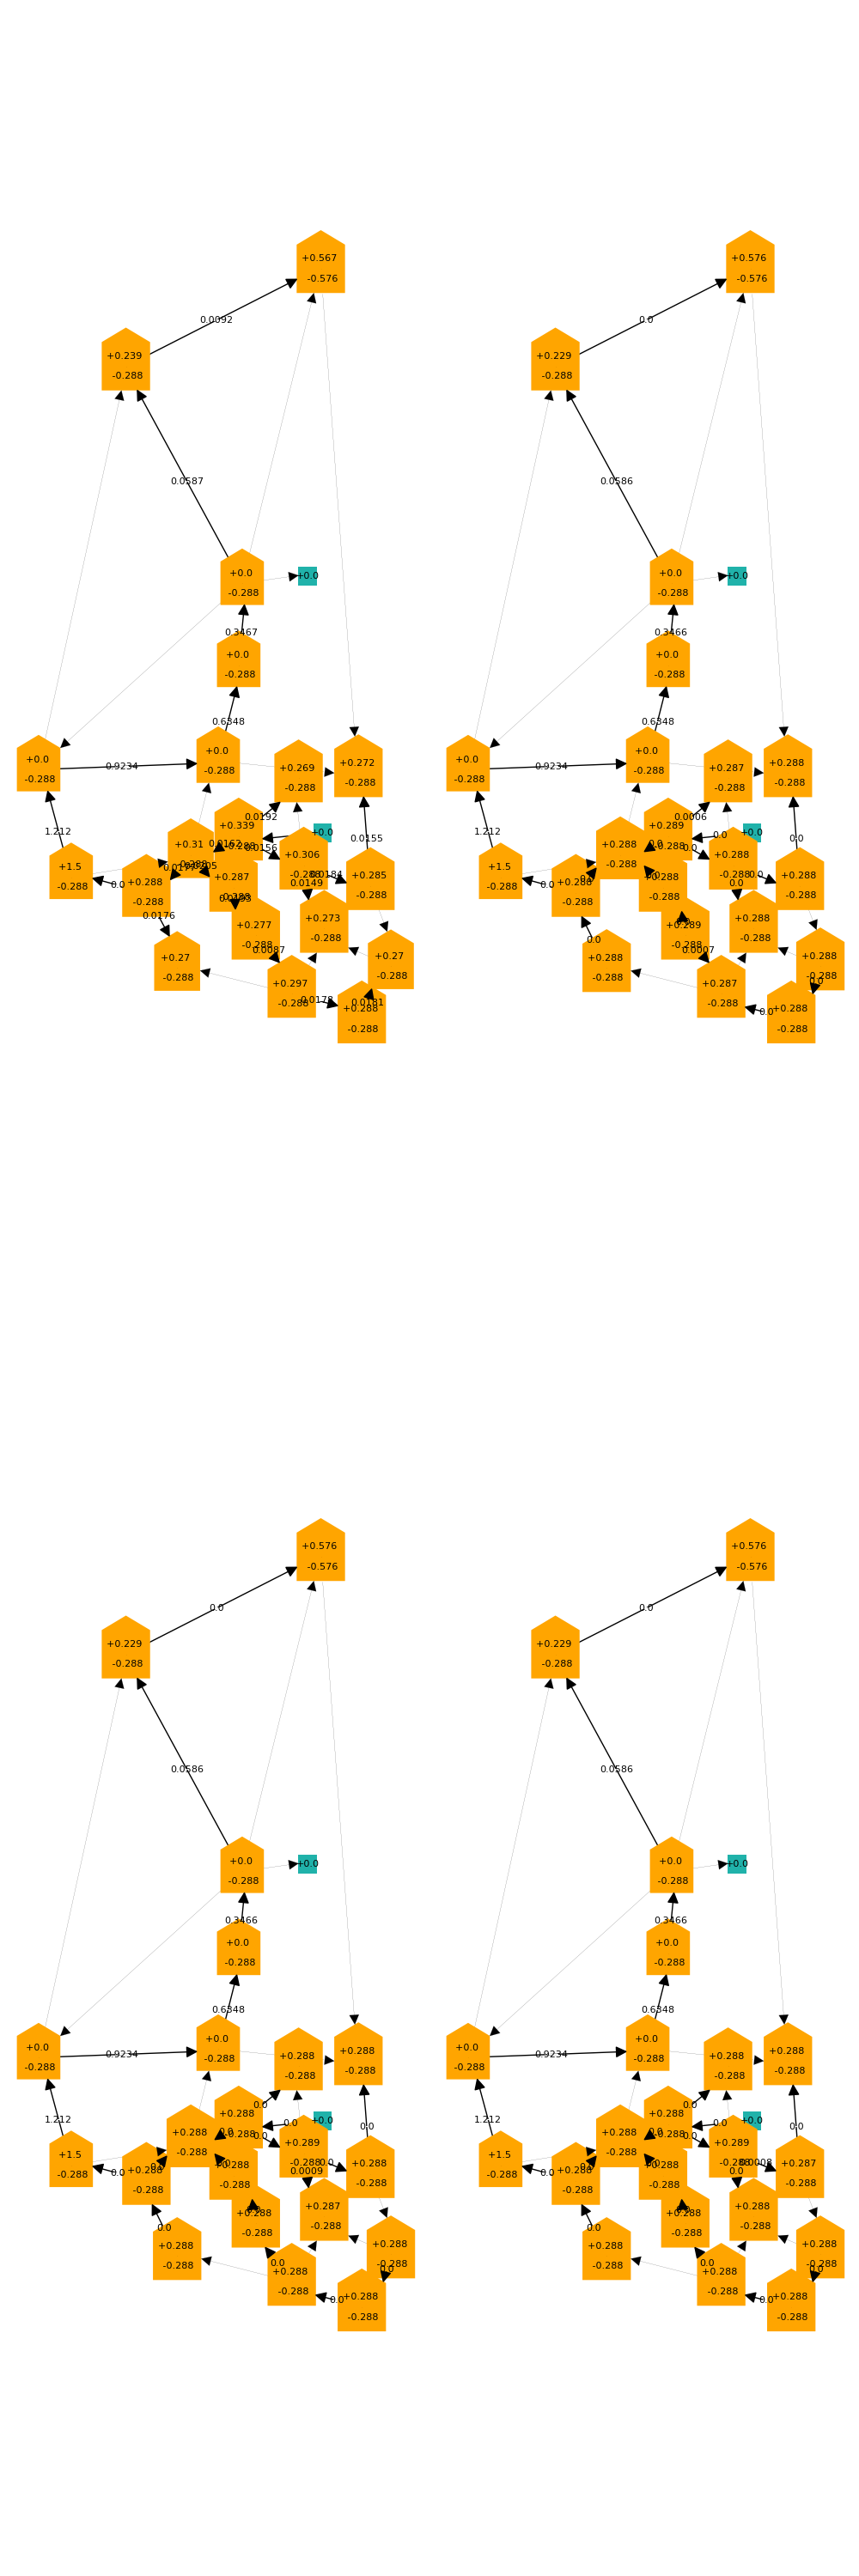

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


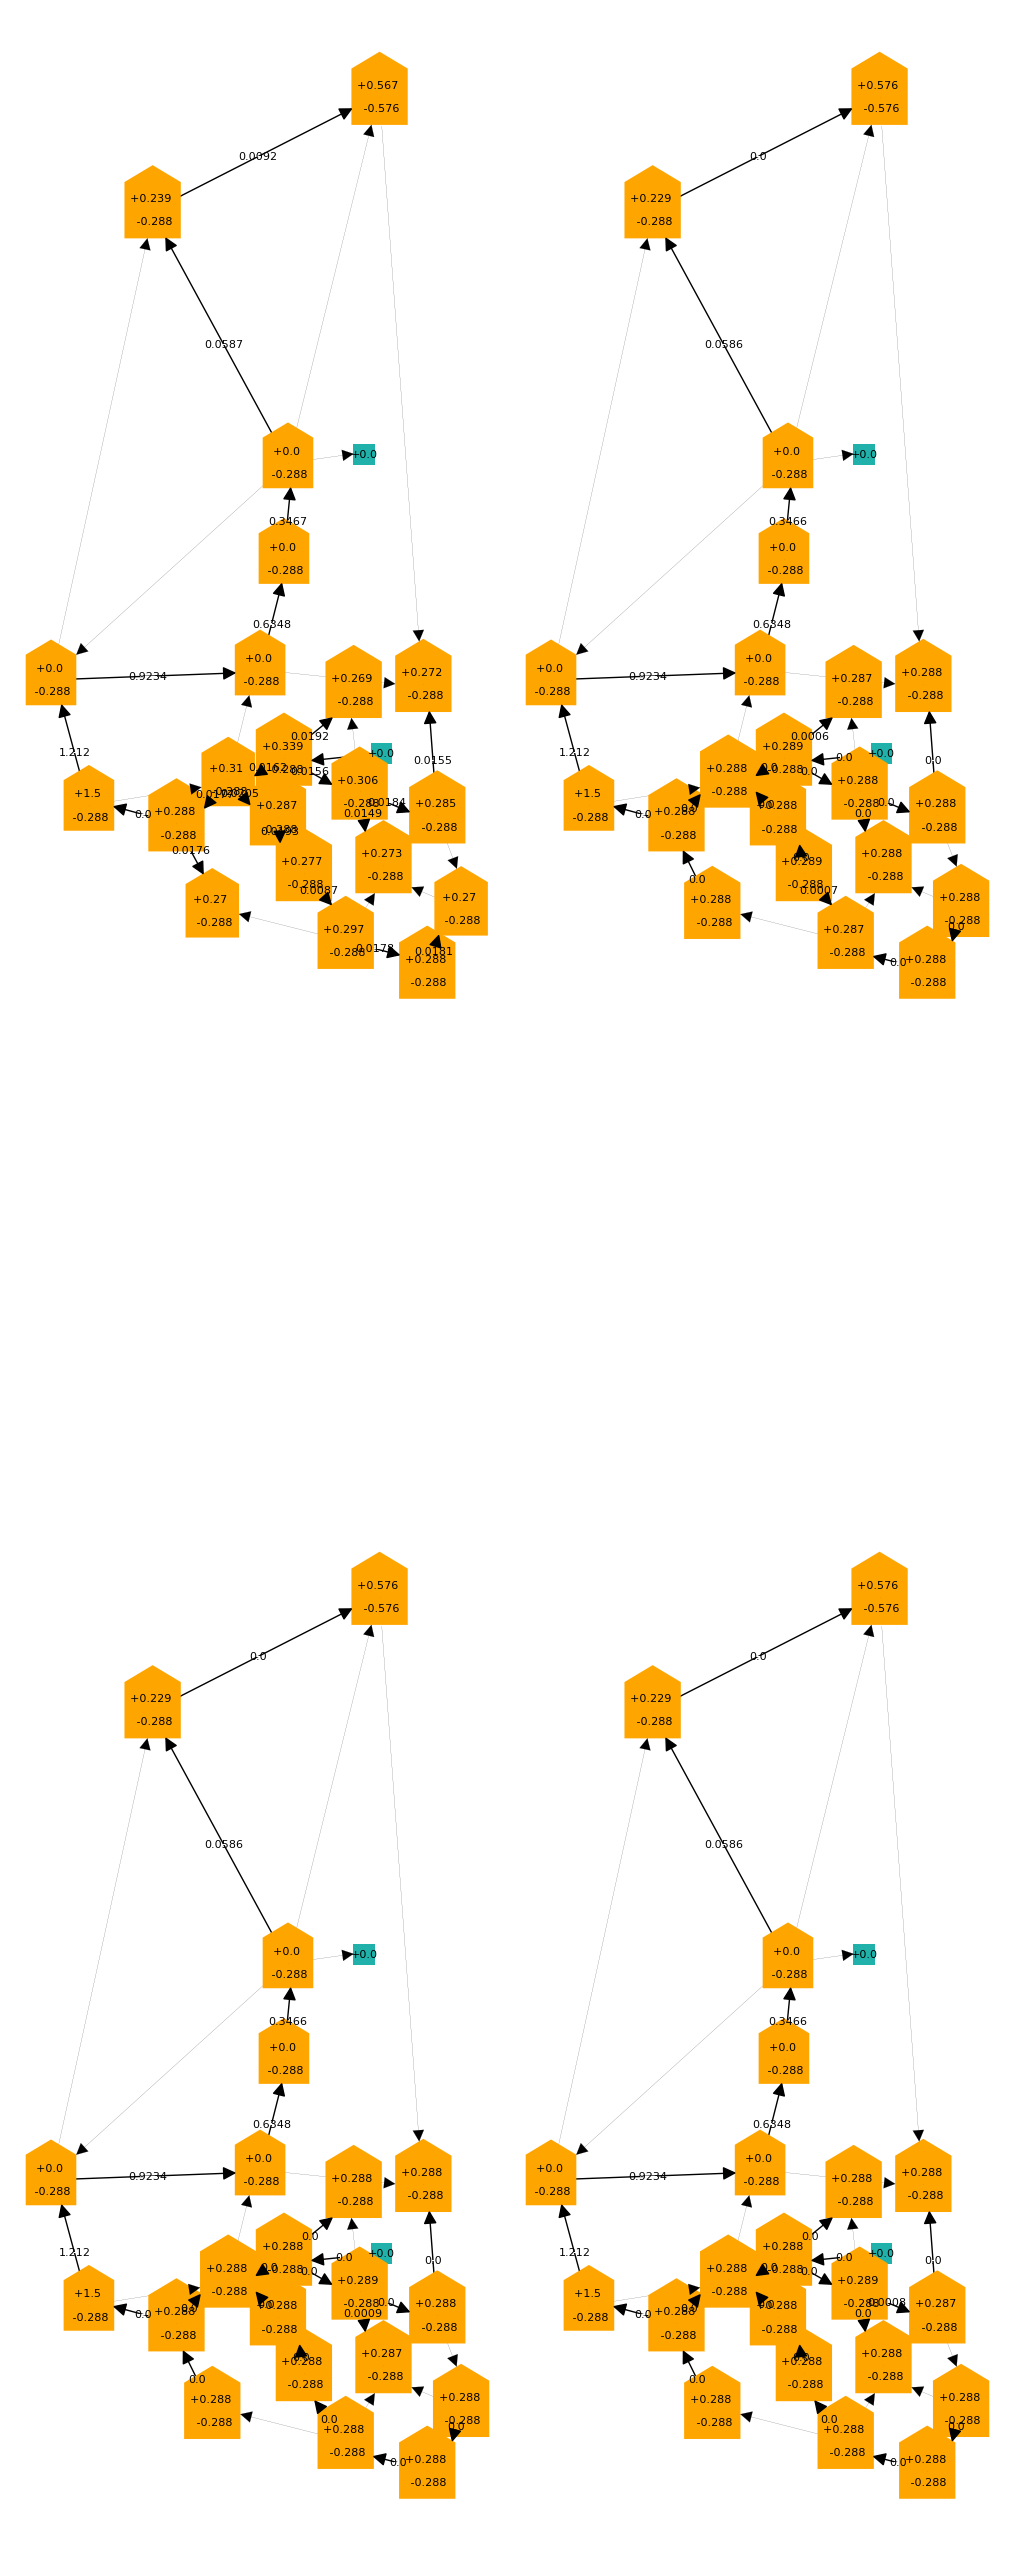

In [47]:
# -- PRINTING THE NETWORK --

pyplot()

graph1 = print_network(length(N), length(Ns), line_ends, rad1_var_values, two_P = false)
graph2 = print_network(length(N), length(Ns), line_ends,  rad2_var_values, two_P = false)
graph3 = print_network(length(N), length(Ns), line_ends,  rad3_var_values, two_P = false)
graph4 = print_network(length(N), length(Ns), line_ends,  rad4_var_values, two_P = false)

display(Plots.plot(graph1, graph2, graph3, graph4, layout=(2, 2)))

[comment]: <> (Section)
<hr style="color:#c6cde1;">
<p align="center">
    <b style="font-size:2vw; color:#c6cde1;">
    6. Functions that verify the results
    </b>
</p>
<hr style="color:#c6cde1;">

[comment]: <> (Description)
<p align="justify">
    In this section, one will be able to:
    <ul>
        <li style="margin-bottom:10px">Set the parameters that are required in the objective function;</li>
    </ul> 

In [ ]:
P_G   = BFM1P_var_values["P_G"]
Q_G   = BFM1P_var_values["Q_G"]
S_G   = BFM1P_var_values["S_G"]
P_ij  = BFM1P_var_values["P_ij"]
Q_ij  = BFM1P_var_values["Q_ij"]
V_sqr = BFM1P_var_values["V_sqr"]
I_sqr = BFM1P_var_values["I_sqr"]

In [ ]:
# -- BFM1P: OPTIMALITY VERIFICATION --

@testset verbose = true "Checking optimality BFM" begin
    
    @testset "Conic constraints $i" for i in N
        @test S_G[i]^2 ≈ P_G[i]^2 + Q_G[i]^2 rtol=1e-5
    end
    @testset "Rotated Conic constraints ($l)" for l in L
        @test V_sqr[line_ends[l][1]] * I_sqr[l] ≈ P_ij[l]^2 + Q_ij[l]^2 rtol=1e-5
    end
end

In [ ]:
P_G   = BFM2P_var_values["P_G"]
Q_G   = BFM2P_var_values["Q_G"]
S_G   = BFM2P_var_values["S_G"]
P_ij  = BFM2P_var_values["P_ij"]
P_ji  = BFM2P_var_values["P_ji"]
Q_ij  = BFM2P_var_values["Q_ij"]
Q_ji  = BFM2P_var_values["Q_ji"]
V_sqr = BFM2P_var_values["V_sqr"]
I_sqr = BFM2P_var_values["I_sqr"]

In [ ]:
# -- BFM2P: OPTIMALITY VERIFICATION --

@testset verbose = true "Checking optimality BFM" begin
    
    @testset "Conic constraints $i" for i in N
        @test S_G[i]^2 ≈ P_G[i]^2 + Q_G[i]^2 rtol=1e-5
    end
    @testset "Rotated Conic constraints sending ($l)" for l in L
        @test V_sqr[line_ends[l][1]] * I_sqr[l] ≈ P_ij[l]^2 + Q_ij[l]^2 rtol=1e-5
    end
    @testset "Rotated Conic constraints receiving ($l)" for l in L
        @test V_sqr[line_ends[l][2]] * I_sqr[l] ≈ P_ji[l]^2 + Q_ji[l]^2 rtol=1e-5
    end
end

In [ ]:
# -- BFM1P: LOSSES VERIFICATION --


